# Chromagram Segmentation

This notebook details a comprehensive process for segmenting a beat-synchronous chromagram, employing advanced methodologies to improve pattern recognition and computational efficiency in music analysis.

## Process Overview

1. **Extract Beat-Synchronous Chromagram**
2. **Stack Time-Lagged Chroma with Reflection Padding**
3. **Compute the Self-Similarity Correlation Matrix (SSM)**
4. **Apply Median Filtering**
5. **Identify Repeating Segments and Handle Overlapping Segments**
6. **Greedy Algorithm for Segment Selection**

## 1. Extract Beat-Synchronous Chromagram

### 1.1 Beat Tracking with Dynamic Programming

Beat tracking aligns chroma features with an audio signal's beats, crucial for matching harmonic content with musical structure. Librosa's functionality streamlines this through dynamic programming, enhancing beat occurrence analysis.

- **Onset Strength Signal ($O(t)$):** Quantifies beat likelihood at time $t$, using a high-pass filtered sum of frequency-wise rectified derivatives of the spectrogram:
  
  $$O(t) = \text{High-pass filter}\left( \sum_{\text{frequency}} \text{Rectify}\left( \frac{\partial}{\partial t} \text{Spectrogram}(t) \right) \right)$$
  
- **Tempo Estimation:** Utilizes $O(t)$'s autocorrelation, focusing on tempos near the preferred tapping rate for tempo estimation:
  
  $$A(\tau) = \text{Autocorrelation}(O(t), \tau) \cdot \text{Gaussian}(\log(\tau), \mu, \sigma)$$
  
- **Dynamic Programming Optimization:** Finds the optimal beat sequence, balancing onset strength and tempo consistency:
  
  $$C(t) = O(t) + \max_{t' < t} \left( C(t') - \alpha \cdot \left( \log\left(\frac{t - t'}{\tau_{\text{est}}}\right) \right)^2 \right)$$

### 1.2 Key-Invariant Chroma Calculation and Beat-Synchronous Chromagram Construction

This step ensures that the chroma representation remains key-invariant, aligning chroma vectors with beat times.

$$\text{KeyShift} = argmax_{k} (\text{Correlate}(\text{ChromaVals}, \text{Profile}_{\text{maj/min}})) \mod 12$$

## 2. Stack Time-Lagged Chroma with Reflection Padding

This process enhances pattern recognition by incorporating historical context into the chromagram.

$$\text{StackedChromagram} = \bigcup_{i=1}^{n} \text{ReflectPad}(\text{Chromagram}, \text{delay}=i)$$

## 3. Compute the Self-Similarity Correlation Matrix (SSM)

The SSM is computed using the correlation matrix of the chromagram to capture the intricate relationships between different parts of a song. This matrix provides insights into repeating patterns and structures by quantifying the similarity between chroma vectors across beats.

- **SSM Calculation:**

  $$S(i, j) = \text{corr}(C[:, i], C[:, j])$$

  Where:
  - `S(i, j)`: The similarity score between the chroma vectors at beats `i` and `j`, indicating how closely these segments are related in terms of their harmonic content.
  - `\text{corr}(\cdot)`: Represents the correlation function, which measures the degree of similarity between two chroma vectors. A higher correlation value suggests a greater similarity between the compared segments.
  - `C[:, i], C[:, j]`: Chroma vectors at beats `i` and `j`, respectively. These vectors contain information about the intensity of each of the 12 semitones (or pitch classes) at the specified beats, encapsulating the harmonic structure at those moments in the song.


### Enhancing the SSM

After calculating the SSM, it is further enhanced using the `librosa.segment.path_enhance` function. This enhancement step improves the visibility of repeating patterns and structures within the SSM by applying a path enhancement filter [4].

- **Path Enhancement Process:**

  The enhancement is achieved with parameters tailored to highlight and clarify the paths representing repeated segments in the music:

  - `n=51`: Specifies the length of the filter, affecting the extent of enhancement along the paths.
  - `window='hann'`: Chooses the Hann window for the filter, smoothing the enhancement effect.
  - `n_filters=7`: Sets the number of filters used, refining the clarity of repeating structures.
  - `zero_mean=False`: Determines the filter's mean behavior, here allowing the filter to retain the original mean of the data.
  - `clip=True`: Ensures that enhanced values are clipped to the original value range, preventing distortion.


## 4. Apply Median Filtering

Median filtering is applied to the SSM to smooth out noise and minor variations, making it easier to identify repeating structures within the song.

- **Median Filtering Process:**

  $$R' = \text{MedianFilter}(R, \text{kernel\_size}=5)$$

  Where:
  - `R'`: The resulting matrix after applying median filtering to the SSM, `R`.
  - `\text{kernel\_size}=5`: The dimensions of the filter used, affecting the degree of smoothing. A size of 5 is chosen to effectively balance detail preservation with noise reduction.

## 5. Identify Repeating Segments and Handle Overlapping Segments

Segments exhibiting repetition are identified using a quantile-based thresholding approach [3].

- **Repeating Segment Identification:**

  $$\text{RepeatingSegments} = \{ (i, l) \mid \text{Quantile}(\text{DiagonalScores}_{i,l}, p) > ts \}$$

  Where:
  - `(i, l)`: Identifies a segment starting at beat `i` with length `l`.
  - `\text{DiagonalScores}_{i,l}`: Similarity scores along the diagonals of the SSM, indicating repetition.
  - `p`: The quantile probability threshold, determining significance levels for identifying repetitions.
  - `ts`: The similarity score threshold, ensuring only segments with scores above this value are considered.

## 6. Greedy Algorithm for Segment Selection

A greedy strategy is employed to select the most representative and non-overlapping segments, optimizing coverage of the song's structure.

- **Segment Selection Criteria:**

  Segments are chosen based on their length and similarity scores, prioritizing those that cover significant portions of the song's structure without overlapping


## References

- [1] Ellis, Daniel P. W. "Beat Tracking by Dynamic Programming." Journal of New Music Research, 2007. Discusses dynamic programming for beat tracking.
- [2] Krumhansl, Carol L. "Cognitive Foundations of Musical Pitch." Oxford University Press, 1990. Introduces the key-finding algorithm used for key-invariant chroma calculation.
- [3] Mauch, M., Noland, K., and Dixon, S. "Using Musical Structure to Enhance Automatic Chord Transcription." ISMIR, 2009.
- [4] Müller, Meinard, et al. "Enhancing Similarity Matrices for Music Audio Analysis." ISMIR, Year.

In [228]:
import glob
import os
import random
import pandas as pd
import numpy as np
import librosa
import librosa.display
from scipy.signal import medfilt2d
from scipy.stats import pearsonr, mstats, scoreatpercentile
import scipy.ndimage 
from scipy.stats.mstats import mquantiles
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from math import floor
from collections import defaultdict

# Utility Functions

In [376]:
def generate_beats_and_meters(beats, sr, hop_length,tempo, duration, time_signature=4):
    """Generate beat and meter grids within the duration of a song."""
    first_beat_time = librosa.frames_to_time(beats[0], sr=sr, hop_length=hop_length)
    seconds_per_beat = 60.0 / tempo
    beats_per_meter = time_signature
    seconds_per_meter = seconds_per_beat * beats_per_meter
    beat_grid_forward = [first_beat_time + i * seconds_per_beat for i in range(int((duration - first_beat_time) / seconds_per_beat))]
    beat_grid_backward = [first_beat_time - i * seconds_per_beat for i in range(1, int(first_beat_time / seconds_per_beat) + 1)]
    beat_grid_backward.reverse()
    beat_grid = beat_grid_backward + beat_grid_forward
    meter_grid_forward = [first_beat_time + i * seconds_per_meter for i in range(int((duration - first_beat_time) / seconds_per_meter))]
    meter_grid_backward = [first_beat_time - i * seconds_per_meter for i in range(1, int(first_beat_time / seconds_per_meter) + 1)]
    meter_grid_backward.reverse()
    meter_grid = meter_grid_backward + meter_grid_forward

    return beat_grid, meter_grid

def calculate_ki_chroma(chromagram, sr, hop_length):
    """Calculate a key-invariant chromagram for a given audio waveform using KS key-finding algorithm."""
    chroma_vals = np.sum(chromagram, axis=1)
    maj_profile = np.array([6.35, 2.23, 3.48, 2.33, 4.38, 4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88])
    min_profile = np.array([6.33, 2.68, 3.52, 5.38, 2.60, 3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17])
    maj_corrs = np.correlate(chroma_vals, maj_profile, mode='same')
    min_corrs = np.correlate(chroma_vals, min_profile, mode='same')
    key_shift = np.argmax(np.concatenate((maj_corrs, min_corrs))) % 12
    return np.roll(chromagram, -key_shift, axis=0)


def apply_diagonal_median_filter(ssm, filter_length=5):
    """Apply a median filter diagonally across a self-similarity matrix (SSM)."""
    # Assuming ssm is square
    ssm_filtered = np.zeros_like(ssm)
    for d in range(-ssm.shape[0] + 1, ssm.shape[1]):
        diag = np.diagonal(ssm, offset=d)
        filtered_diag = scipy.ndimage.median_filter(diag, size=filter_length)
        if d >= 0:
            np.fill_diagonal(ssm_filtered[:,d:], filtered_diag)
        else:
            np.fill_diagonal(ssm_filtered[-d:,:], filtered_diag)
    return np.abs(ssm_filtered)


def find_repetitions(ssm, beat_grid_frames, min_length=12, max_length=128, p=0.1, ts=0.65):
    repetitions = {}
    for i in range(len(beat_grid_frames)):
        for length in range(min_length, max_length + 1, 4):
            for j in range(i + 1, len(beat_grid_frames)):  # Ensure j > i to avoid self-comparison
                if j - i < length:
                    continue
                # Extract the diagonal segment D_{i,j,l}
                Di_j_l = ssm[i:i+length, j:j+length].diagonal()
                quantile_value = scoreatpercentile(Di_j_l, p*100)
                if quantile_value > ts:
                    key = (i, length)
                    repetitions.setdefault(key, []).append((j, quantile_value))

    # Construct L, ensuring R_il sets with more than one j are included, and filter for best j score in case of overlap
    L = []
    for (i, l), js in repetitions.items():
        # Sort js by score to ensure the highest score is considered first
        sorted_js = sorted(js, key=lambda x: x[1], reverse=True)
        if len(sorted_js) > 1:
            # Include only the highest scoring j for each i, l pair
            best_j, best_score = sorted_js[0]
            L.append({'i': i, 'j': best_j, 'l': l, 'score': best_score})

    return L

def plot_repetitions(ssm_1, repeating_segments_1, ssm_2, repeating_segments_2, padding_correction=0, algo=""):
    """Plotting and comparing SSMs and greedy selection algorithms with labels on repeating segments."""
    fig, axs = plt.subplots(1, 2, figsize=(20, 10), sharey=True, sharex=True)

    # Minimum and maximum similarity scores for the shared color bar
    vmin = min(np.min(ssm_1), np.min(ssm_2))
    vmax = max(np.max(ssm_1), np.max(ssm_2))

    # Plot settings
    cmap = 'viridis'
    aspect = 'equal'
    origin = 'lower'

    # Function to plot each SSM and its repeating segments
    def plot_ssm(ax, ssm, repeating_segments):
        ax.imshow(ssm, aspect=aspect, origin=origin, cmap=cmap, vmin=vmin, vmax=vmax)
        for idx, segment in enumerate(repeating_segments):
            i, j, l, score = segment['i'], segment['j'], segment['l'], segment['score']
            i_corrected = max(i - padding_correction, 0)
            j_corrected = max(j - padding_correction, 0)

            # Draw rectangles
            rect_ij = patches.Rectangle((j_corrected, i_corrected), l, l, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect_ij)

            rect_ji = patches.Rectangle((i_corrected, j_corrected), l, l, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect_ji)

            # Add labels in the middle of the rectangles
            label_text = f"Pattern {idx + 1}, {round(score*100)}% match, {l} beats"
            ax.text(j_corrected + l/2, i_corrected + l/2, label_text, ha='center', va='center', color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))
            ax.text(i_corrected + l/2, j_corrected + l/2, label_text, ha='center', va='center', color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))

    # Plot the first SSM and its segments
    plot_ssm(axs[0], ssm_1, repeating_segments_1)
    axs[0].set_title('Median Filtered SSM')

    # Plot the second SSM and its segments
    plot_ssm(axs[1], ssm_2, repeating_segments_2)
    axs[1].set_title('Enhanced SSM')

    # Set the axis labels for the figure
    fig.text(0.5, 0.04, 'Time (beat frames)', ha='center')
    fig.text(0.04, 0.5, 'Time (beat frames)', va='center', rotation='vertical')
    
    # Set the main plot title based on the algo parameter
    if algo:
        fig.suptitle(f"{algo} Selection Results", fontsize=16)

    # Shared color bar for both subplots
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(sm, ax=axs.ravel().tolist(), orientation='vertical', fraction=0.02, pad=0.04)
    cbar.set_label('Similarity Score')

    plt.show()

# Load Audio, Extract Features, and Create Beat-Synchronous Chromagram

In [348]:
SR = 12000 # Target sample rate chosen to be 1/4 of the original 48kHz.
HOP_LENGTH = 128    # Hop length for short-time Fourier transform. 
                    # 128 at 12kHz gives a similar frame rate to a hop length of 512 at 48kHz.

# Load a random song from the test set
file_pattern = '../data/audio_files/processed/*.mp3'
song_ids = [os.path.basename(f).split('.')[0] for f in glob.glob(file_pattern)]
random.seed(42)
random_song_id = random.choice(song_ids)
audio_file = f'../data/audio_files/processed/{random_song_id}.mp3'

# Load the audio and extract beat features
y, _ = librosa.load(audio_file, sr=SR)
y_harm, y_perc = librosa.effects.hpss(y) # Harmonic and percussive source separation 
onset_env = librosa.onset.onset_strength(y=y_perc, sr=SR, hop_length=HOP_LENGTH)
duration = librosa.get_duration(y=y, sr=SR)
frame_duration = len(onset_env)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=SR, hop_length=HOP_LENGTH)
beat_grid, meter_grid = generate_beats_and_meters(beats, SR, HOP_LENGTH, tempo, duration, time_signature=4)
beat_grid_frames = librosa.time_to_frames(beat_grid, sr=SR, hop_length=HOP_LENGTH)
meter_grid_frames = librosa.time_to_frames(meter_grid, sr=SR, hop_length=HOP_LENGTH)
quantized_beats = np.intersect1d(beat_grid_frames, meter_grid_frames)
beat_grid_frames = librosa.util.fix_frames(beat_grid_frames)

# Extract chromagram and sync with beats
chromagram = librosa.feature.chroma_cqt(y=y_harm, sr=SR, hop_length=HOP_LENGTH, bins_per_octave=24)
chroma = (chromagram - chromagram.min()) / (chromagram.max() - chromagram.min()) # Normalize chromagram
chroma_ki = calculate_ki_chroma(chroma, SR, HOP_LENGTH)
chroma_sync = librosa.util.sync(chroma_ki, beat_grid_frames, aggregate=np.median) # Sync chromagram with beats with median aggregation 

## Visualizing the beat-synced chromagrams

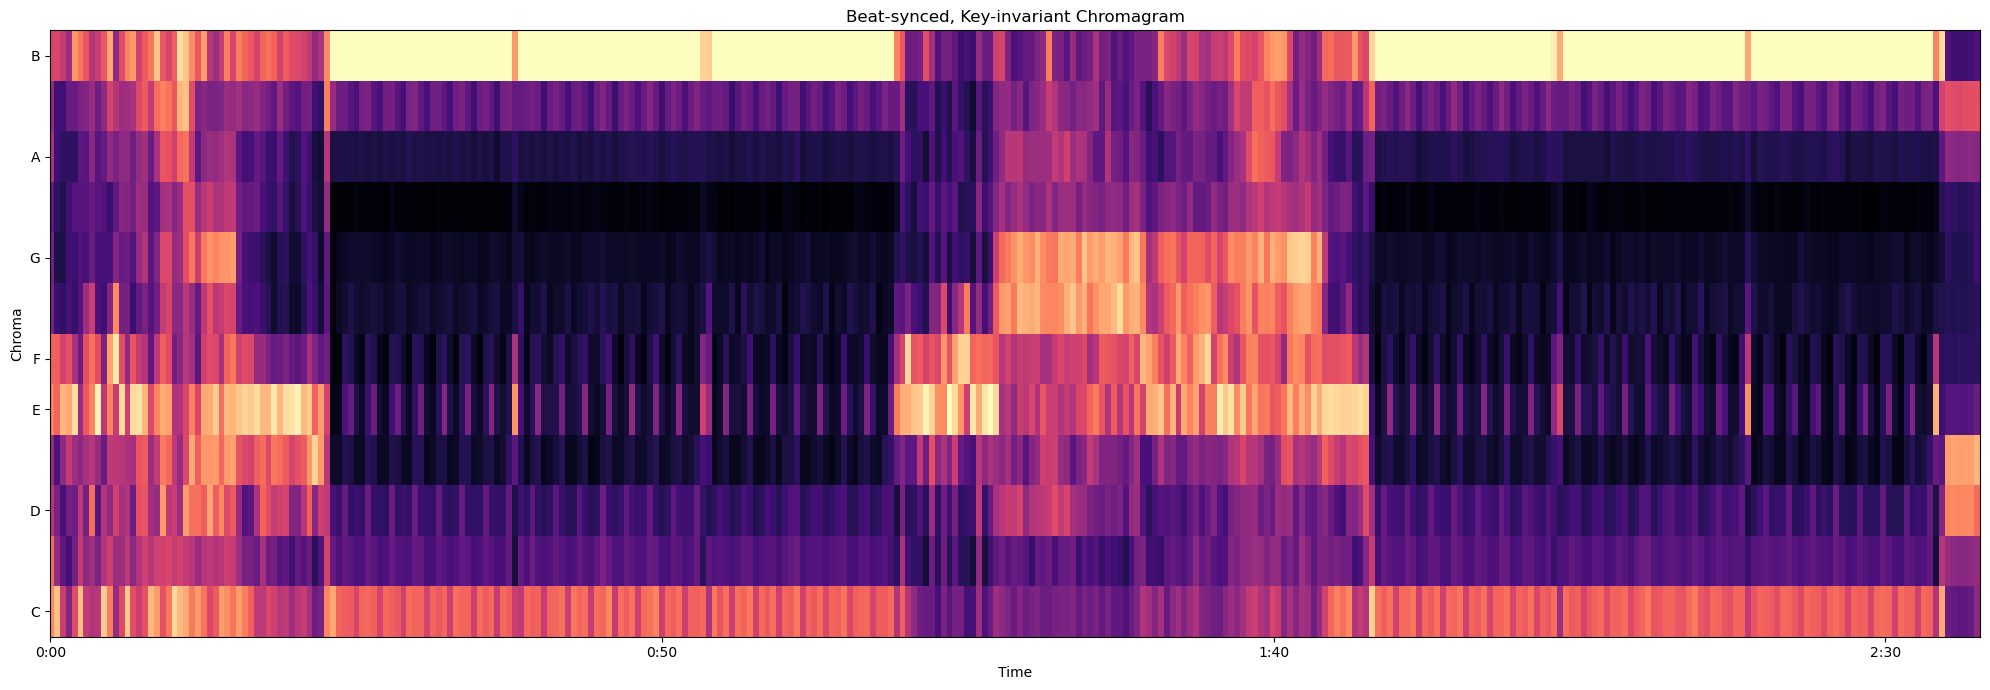

In [349]:
fig, ax = plt.subplots(figsize=(20, 7))
beat_grid_times = librosa.frames_to_time(beat_grid_frames, sr=SR, hop_length=HOP_LENGTH)
librosa.display.specshow(chroma_sync, sr=SR, y_axis='chroma', x_axis='time',
                         x_coords=beat_grid_times, ax=ax, hop_length=HOP_LENGTH)
ax.set_ylabel('Chroma')
ax.set_title('Beat-synced, Key-invariant Chromagram')

plt.tight_layout()
plt.show()

## Calculate SSM and Path Enhancement
- Transpose `chroma_sync` before computing pairwise distances to ensure that the resulting SSM is suitable for identifying repeating segments across time. The size of this SSM will be determined by the number of time frames (or beat-synced frames) in the chroma feature matrix.
- Calculate the SSM using Pearson correlation coefficients
- Take the absolute values of the SSM, scaling the values from [0, 1], making the SSM values more intuitively interpretable in terms of similarity (where 1 represents maximum similarity and 0 represents maximum dissimilarity, in the context of the normalized scale)
- Apply median filter to the normalized SSM
- Path enhancement is used to enhance continuity along diagonal paths in the SSM, which represent repeating musical segments. It's particularly useful for highlighting temporal structures and patterns that recur over time by making repeating paths more pronounced and easier to identify, especially in pieces with complex structures or subtle repetitions.
    - `librosa.segement.path_enhance()` is inspired by the multi-angle path enhancement of [1], but differs by modeling tempo differences in the space of similarity matrices rather than re-sampling the underlying features prior to generating the self-similarity matrix.

[1]
Müller, Meinard and Frank Kurth. “Enhancing similarity matrices for music audio analysis.” 2006 IEEE International Conference on Acoustics Speech and Signal Processing Proceedings. Vol. 5. IEEE, 2006.

In [417]:
chroma_sync_T = chroma_sync.T                 # Transpose chroma_sync to have time frames as rows for correlation calculation
ssm_pearson = abs(np.corrcoef(chroma_sync_T)) # Calculate the SSM using Pearson correlation coefficients

ssm_medfilt = apply_diagonal_median_filter(ssm_pearson, filter_length=5)
ssm_enhanced = librosa.segment.path_enhance(ssm_pearson, n=51, window='hann', n_filters=7, zero_mean=False, clip=True) 

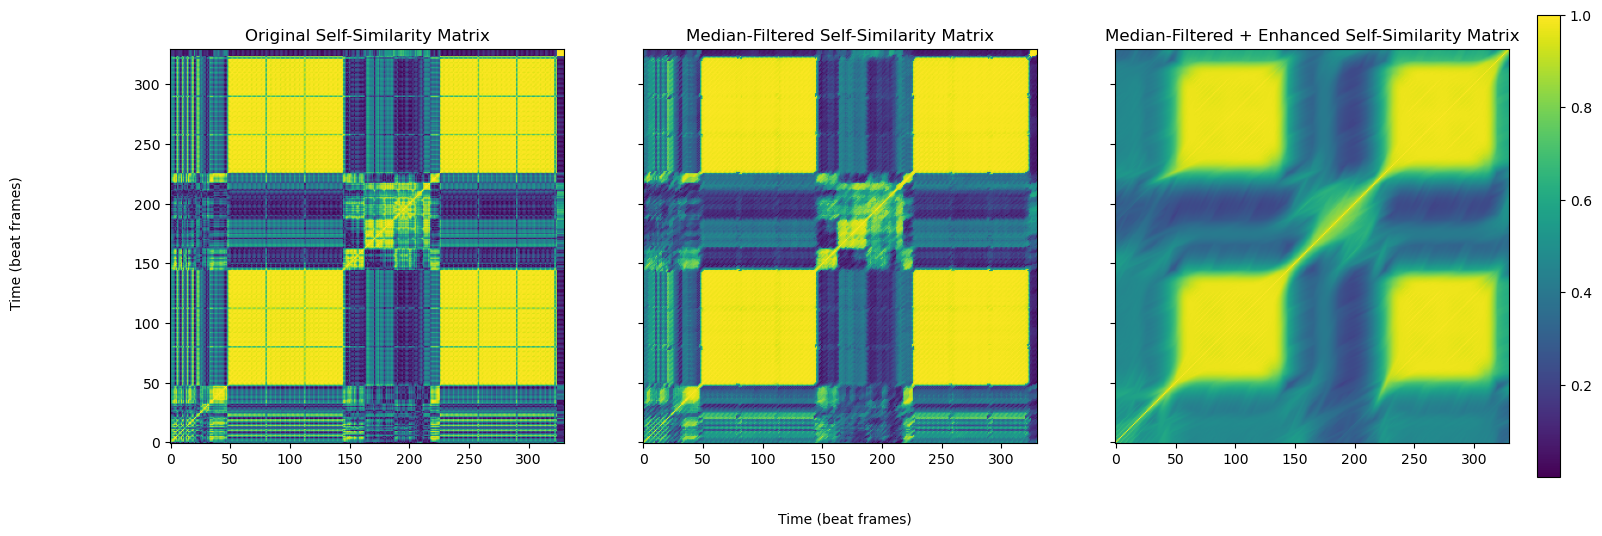

In [424]:
# Find global min and max for color normalization
vmin = min(np.min(ssm_pearson), np.min(ssm_filt), np.min(ssm_enhanced))
vmax = max(np.max(ssm_pearson), np.max(ssm_filt), np.max(ssm_enhanced))

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharex='all', sharey='all')

# Original SSM
img1 = ax[0].imshow(ssm_pearson, aspect='equal', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
ax[0].set_title('Original Self-Similarity Matrix')

# Filtered SSM
img2 = ax[1].imshow(ssm_filt, aspect='equal', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
ax[1].set_title('Median-Filtered Self-Similarity Matrix')

# Enhanced SSM
img3 = ax[2].imshow(ssm_enhanced, aspect='equal', origin='lower', cmap='viridis', vmin=vmin, vmax=vmax)
ax[2].set_title('Median-Filtered + Enhanced Self-Similarity Matrix')

# Set shared labels for the entire figure
fig.text(0.5, 0.04, 'Time (beat frames)', ha='center', va='center')
fig.text(0.04, 0.5, 'Time (beat frames)', ha='center', va='center', rotation='vertical')

# Add a single color bar to the right of the plots
fig.colorbar(img3, ax=ax.ravel().tolist(), location='right', fraction=0.02, pad=0.02)

plt.show()

In [361]:
# Find repetitions for both median filtered and enhanced SSMs
filtered_repetitions_medfilt = find_repetitions(ssm_filt, beat_grid_frames)
filtered_repetitions_enhanced = find_repetitions(ssm_enhanced, beat_grid_frames)

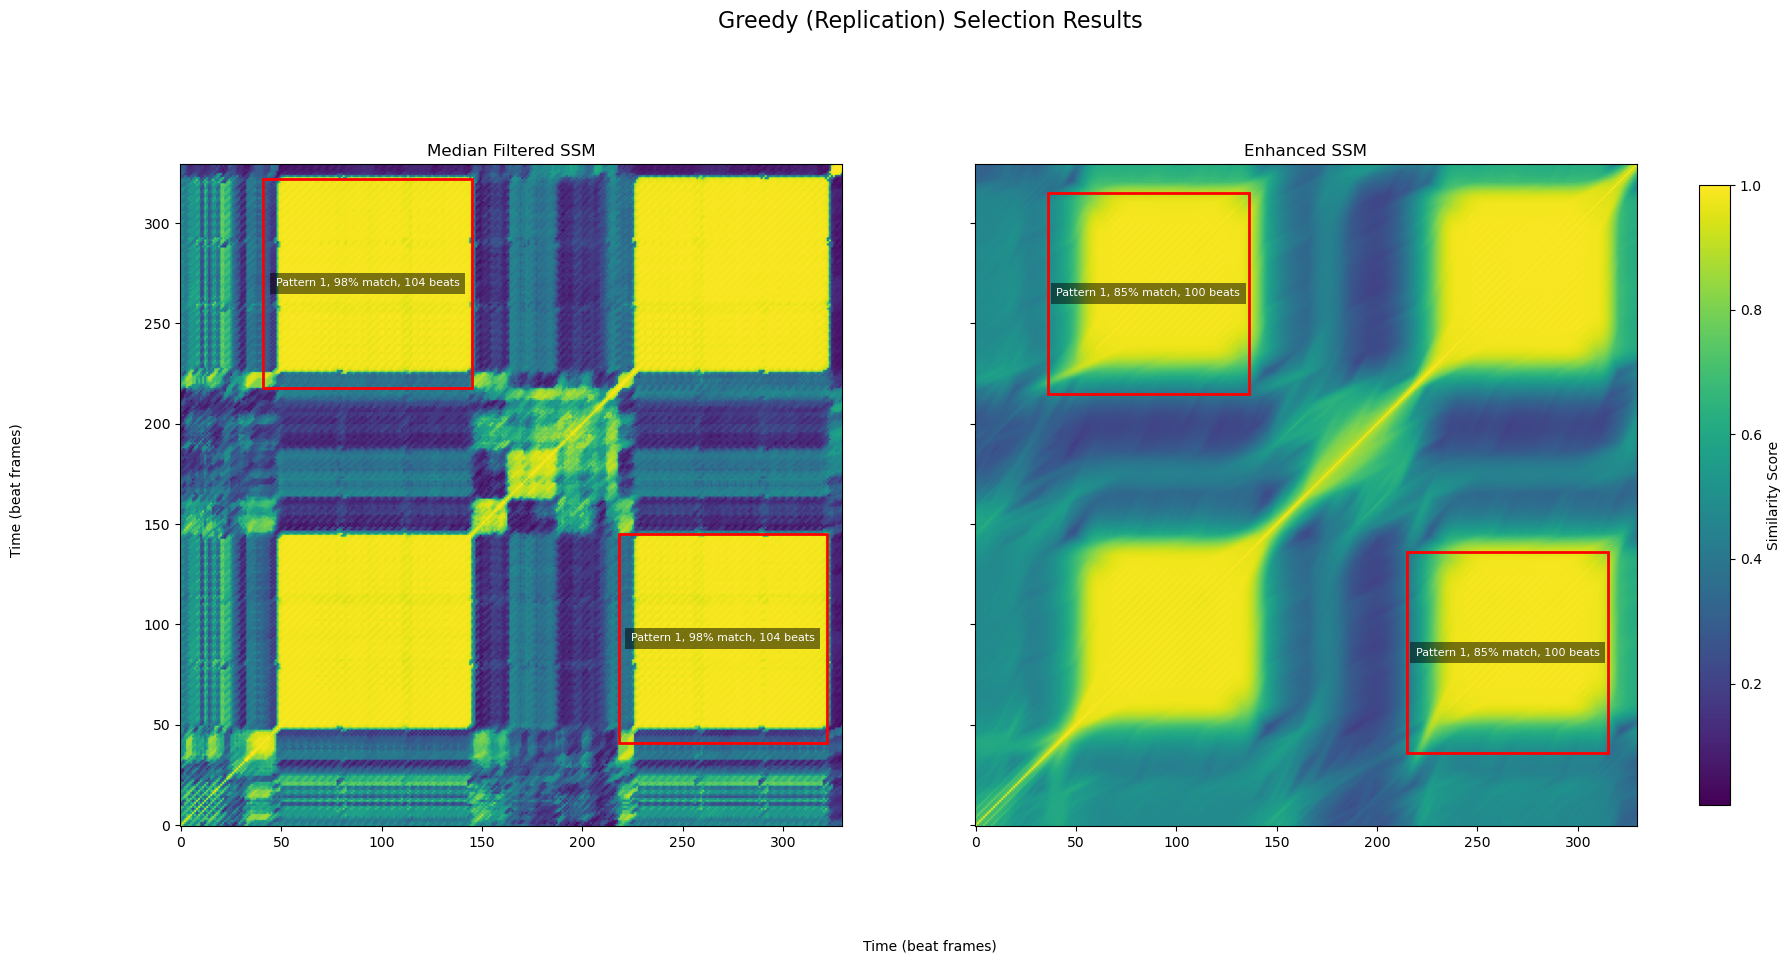

In [378]:
def greedy_select_segments(L):
    """
    Apply a greedy selection algorithm on the list of repetition sets, prioritizing
    the sets based on l * |R_il|, and considering sub-segments with higher scores
    that start at either i or j.

    Parameters:
    - L: List of dictionaries from find_repetitions, each containing 'i', 'j', 'l', and 'score'.
    
    Returns:
    - A list of selected repetition sets based on the greedy algorithm.
    """
    # Initially sort L by l * score in descending order
    sorted_L = sorted(L, key=lambda x: x['l'] * x['score'], reverse=True)

    selected_segments = []
    
    for segment in sorted_L:
        # Assume segment is selected until a better sub-segment is found
        selected = True

        # Evaluate this segment against others to check for sub-segments or overlapping segments with higher scores
        for potential_sub in sorted_L:
            if potential_sub == segment:
                # Skip the same segment comparison
                continue

            # Check for sub-segment starting at 'i' or 'j' with a higher score
            if (potential_sub['i'] == segment['i'] or potential_sub['j'] == segment['j']) and \
               potential_sub['l'] <= segment['l'] and \
               potential_sub['score'] > segment['score']:
                # A sub-segment with a higher score has been found
                selected = False
                break

        if selected:
            selected_segments.append(segment)
            # Once a segment is selected, break to avoid selecting overlapping sub-segments
            break

    return selected_segments

greedy_repetitions_medfilt = greedy_select_segments(filtered_repetitions_medfilt)
greedy_repetitions_enhanced = greedy_select_segments(filtered_repetitions_enhanced)
plot_repetitions(ssm_filt, greedy_repetitions_medfilt, ssm_enhanced, greedy_repetitions_enhanced, padding_correction=0, algo="Greedy (Replication)")

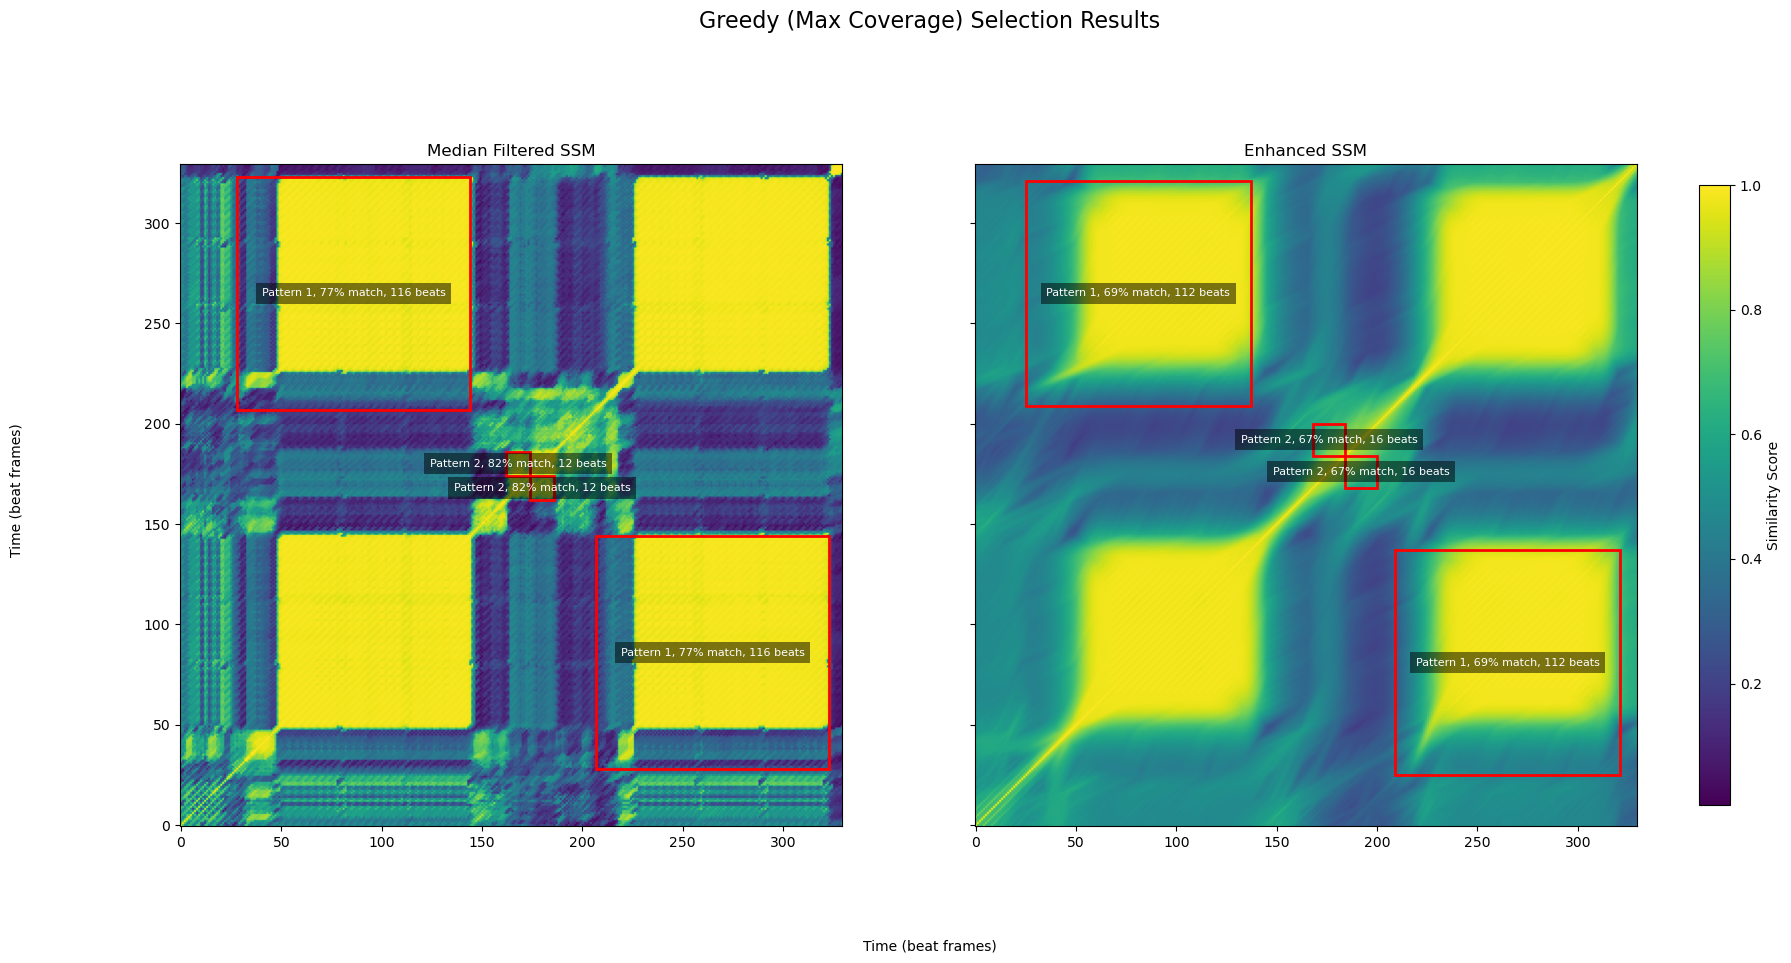

In [379]:
def greedy_select_max_coverage(L, total_frames):
    """
    Apply a greedy selection algorithm on the list of repetition sets, aiming to 
    maximize the number of frames covered by non-overlapping repeating segments, 
    while ensuring that the segment boundaries fit within the song length in frames.
    
    Parameters:
    - L: List of dictionaries from find_repetitions, each containing 'i', 'j', 'l', and 'score'.
    - total_frames: The total number of frames in the song.
    
    Returns:
    - A list of selected repetition sets based on the greedy algorithm, aiming to maximize frame coverage.
    """
    sorted_L = sorted(L, key=lambda x: x['l'], reverse=True)

    selected_segments = []
    covered_frames = set()

    for segment in sorted_L:
        # Calculate the frame span of the current segment and ensure it's within song boundaries
        if segment['i'] + segment['l'] <= total_frames and segment['j'] + segment['l'] <= total_frames:
            i_span = set(range(segment['i'], segment['i'] + segment['l']))
            j_span = set(range(segment['j'], segment['j'] + segment['l']))

            # Ensure no overlap with already covered frames
            if not (i_span & covered_frames or j_span & covered_frames):
                selected_segments.append(segment)
                covered_frames |= i_span
                covered_frames |= j_span

    return selected_segments

# Assuming repeating_segments is populated from the find_repetitions function
total_frames = ssm_filt.shape[0]
greedy_max_coverage_medfilt = greedy_select_max_coverage(filtered_repetitions_medfilt, total_frames)
greedy_max_coverage_enhanced = greedy_select_max_coverage(filtered_repetitions_enhanced, total_frames)
plot_repetitions(ssm_filt, greedy_max_coverage_medfilt, ssm_enhanced, greedy_max_coverage_enhanced, padding_correction=0, algo="Greedy (Max Coverage)")

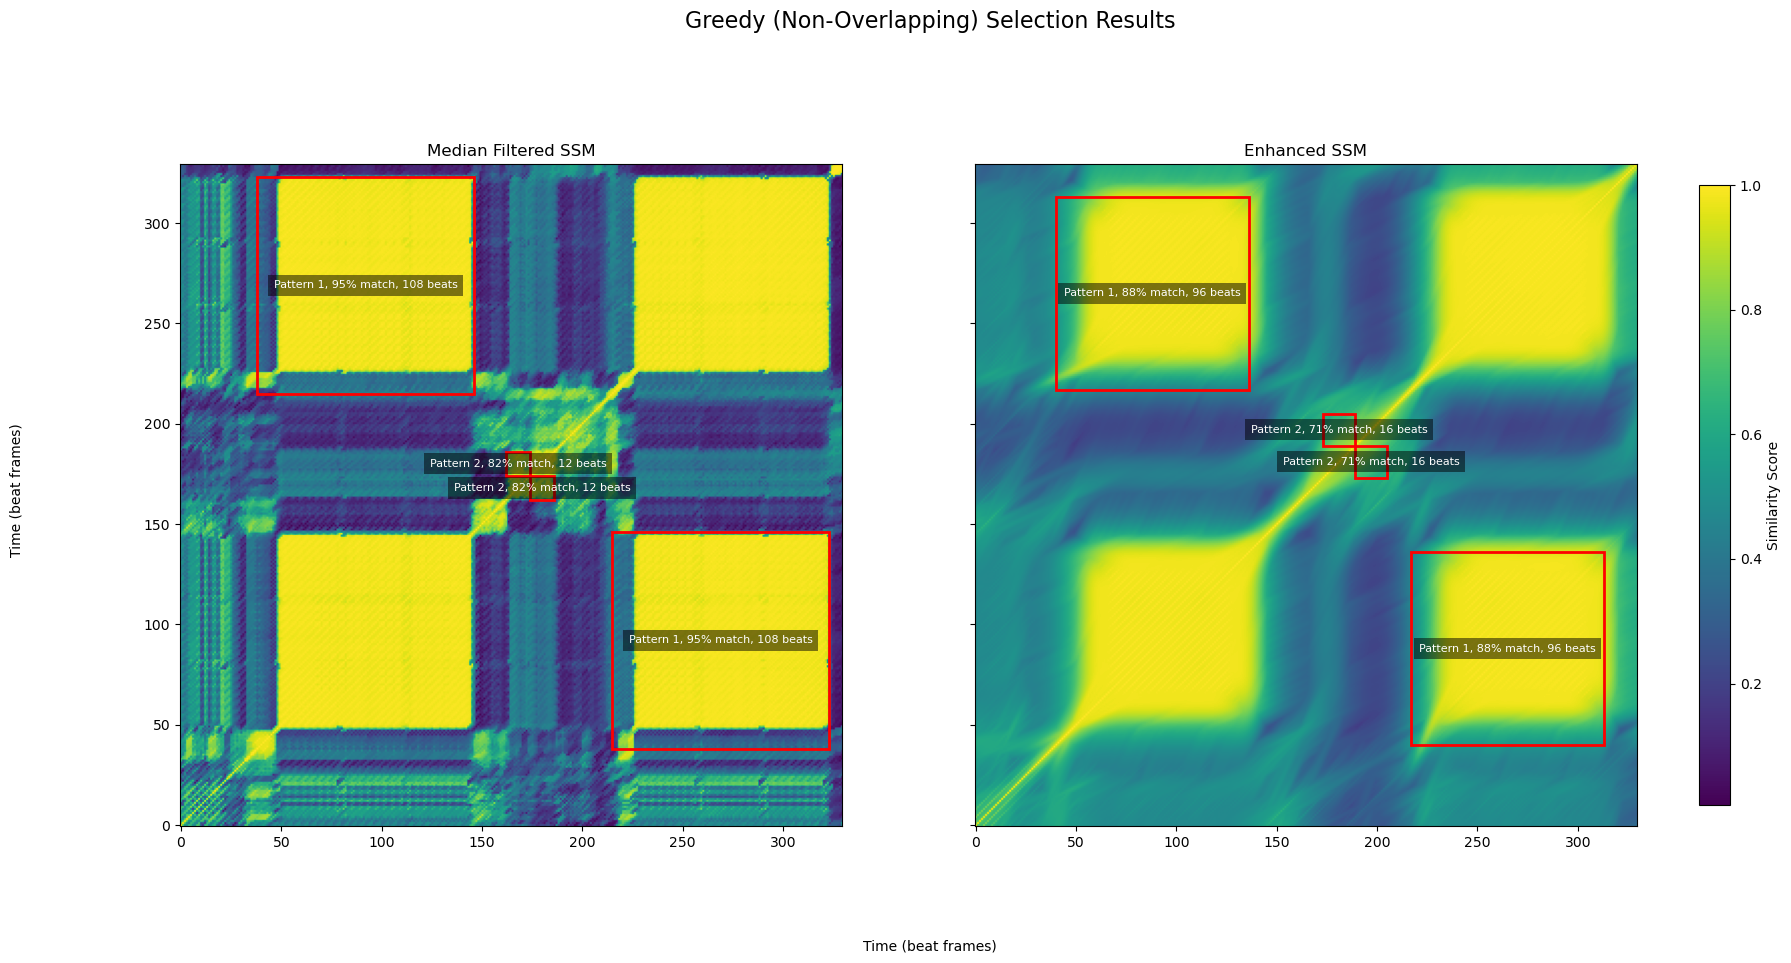

In [381]:
def greedy_select_non_overlapping(L, total_frames):
    """
    Apply a greedy selection algorithm on the list of repetition sets, prioritizing 
    the sets where l * score is maximal, while ensuring that the segment boundaries
    fit within the song length in frames. Any segment that overlaps with a selected 
    segment's range or goes beyond the song boundaries is not considered in further 
    selections.
    
    Parameters:
    - L: List of dictionaries from find_repetitions, each containing 'i', 'j', 'l', and 'score'.
    - total_frames: The total number of frames in the song.
    
    Returns:
    - A list of selected repetition sets based on the greedy algorithm without overlaps
      and within song boundaries.
    """
    # Sort L by l * score in descending order
    sorted_L = sorted(L, key=lambda x: x['l'] * x['score'], reverse=True)

    selected_segments = []
    occupied_ranges = []

    for segment in sorted_L:
        # Ensure the segment does not exceed song boundaries
        if segment['i'] + segment['l'] > total_frames or segment['j'] + segment['l'] > total_frames:
            continue

        i_range = set(range(segment['i'], segment['i'] + segment['l']))
        j_range = set(range(segment['j'], segment['j'] + segment['l']))

        # Check if the current segment overlaps with any previously selected segment
        if any(i_range & occ_range or j_range & occ_range for occ_range in occupied_ranges):
            continue  # Skip this segment due to overlap

        # Add the current segment's range as occupied
        occupied_ranges.append(i_range)
        occupied_ranges.append(j_range)

        # Add this segment to the selection
        selected_segments.append(segment)

    return selected_segments

total_frames = ssm_filt.shape[0]
greedy_non_overlapping_medfilt = greedy_select_non_overlapping(filtered_repetitions_medfilt, total_frames)
greedy_non_overlapping_enhanced = greedy_select_non_overlapping(filtered_repetitions_enhanced, total_frames)
plot_repetitions(ssm_filt, greedy_non_overlapping_medfilt, ssm_enhanced, greedy_non_overlapping_enhanced, padding_correction=0, algo="Greedy (Non-Overlapping)")

In [412]:
def combine_segments(segments, total_length):
    # Initialize list for processed segments with pair numbers
    processed_segments = []
    for idx, seg in enumerate(segments):
        # Assign unique pair numbers starting from 1
        pair_number = idx + 1
        # Append both the segment and its mirror with their respective pair numbers
        processed_segments.extend([
            (seg['i'], seg['i'] + seg['l'], pair_number),
            (seg['j'], seg['j'] + seg['l'], pair_number)
        ])

    # Sort the processed segments by their starting point
    processed_segments.sort(key=lambda x: x[0])

    all_segments = []
    # Initialize last_end to track the end of the last segment added
    last_end = 0

    for start, end, pair_num in processed_segments:
        # Check for a gap between this segment and the last, marking it as non-pattern if found
        if start > last_end:
            all_segments.append((last_end, start, 0))  # Non-pattern segment
        # Update last_end if this segment extends beyond the current last_end
        if end > last_end:
            all_segments.append((start, end, pair_num))
            last_end = end

    # Append a final non-pattern segment if there's remaining space in the total_length
    if last_end < total_length:
        all_segments.append((last_end, total_length, 0))

    return all_segments

combined_greedy_repetitions_medfilt = combine_segments(greedy_repetitions_medfilt, total_frames)
combined_greedy_repetitions_enhanced = combine_segments(greedy_repetitions_enhanced, total_frames)
combined_greedy_max_coverage_medfilt = combine_segments(greedy_max_coverage_medfilt, total_frames)
combined_greedy_max_coverage_enhanced = combine_segments(greedy_max_coverage_enhanced, total_frames)
combined_greedy_non_overlapping_medfilt = combine_segments(greedy_non_overlapping_medfilt, total_frames)
combined_greedy_non_overlapping_enhanced = combine_segments(greedy_non_overlapping_enhanced, total_frames)

In [413]:
combined_greedy_repetitions_medfilt, greedy_repetitions_medfilt

([(0, 41, 0), (41, 145, 1), (145, 218, 0), (218, 322, 1), (322, 330, 0)],
 [{'i': 41, 'j': 218, 'l': 104, 'score': 0.9815941766042706}])

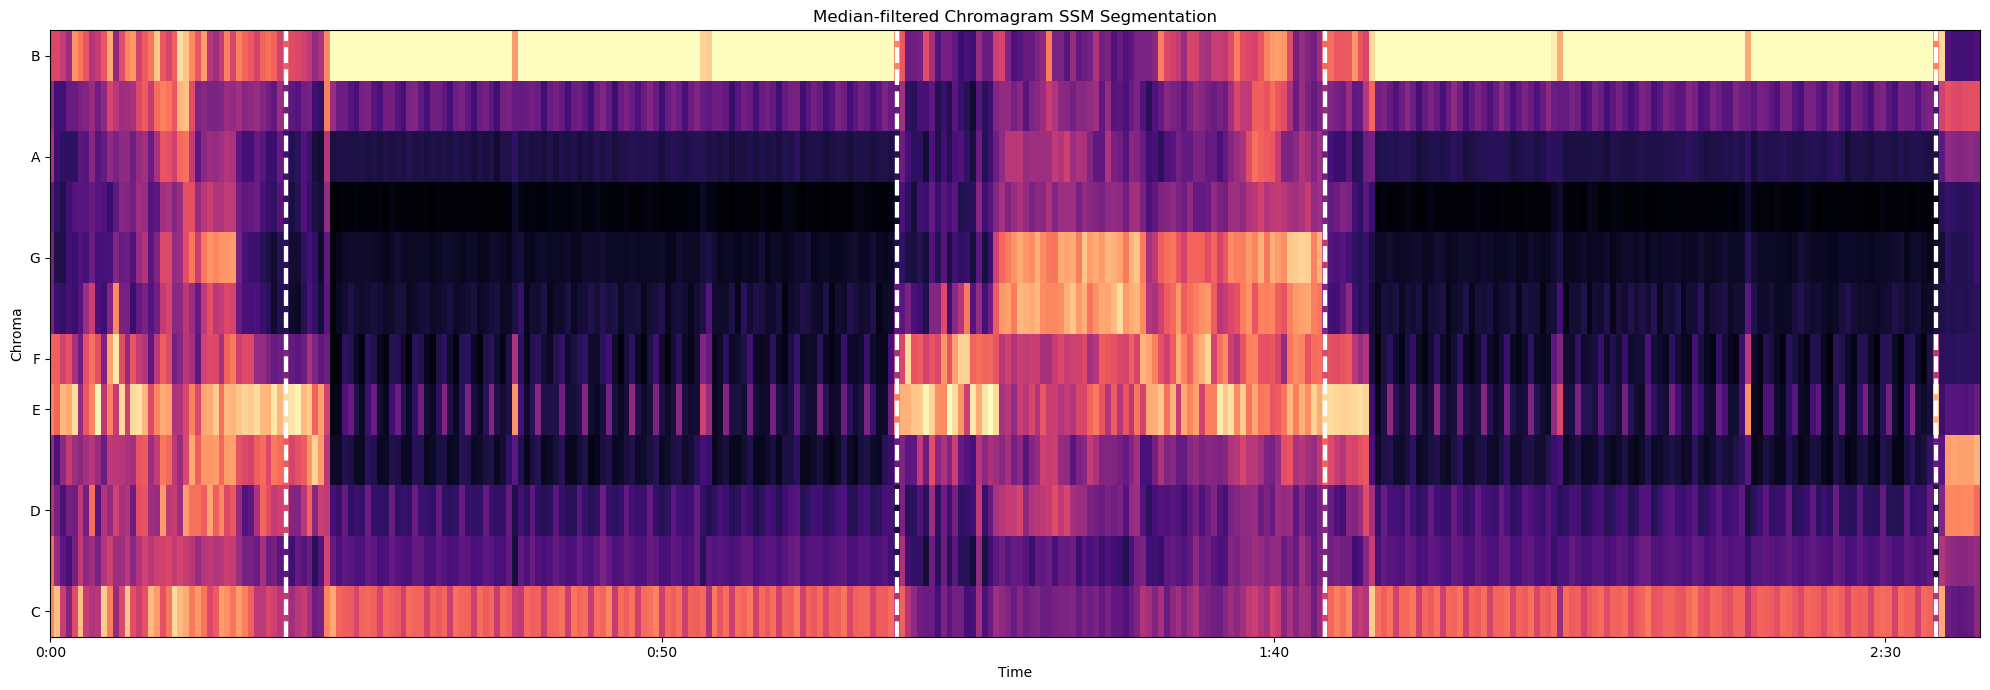

In [416]:
fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.specshow(chroma_sync, sr=SR, y_axis='chroma', x_axis='time',
                         x_coords=beat_grid_times, ax=ax, hop_length=HOP_LENGTH)
ax.set_ylabel('Chroma')
ax.set_title('Median-filtered Chromagram SSM Segmentation')

def plot_segment_lines(ax, segments):
    for segment in segments: 
        if segment[0] > 0:  # Ignore the very start of the song
            start_time = beat_grid_times[segment[0]]
            ax.axvline(x=start_time, color='w', linestyle='--', linewidth=3)
        if segment[1] < total_frames:  # Ignore the very end of the song
            end_time = beat_grid_times[min(segment[1], len(beat_grid_times)-1)]
            ax.axvline(x=end_time, color='w', linestyle='--', linewidth=3)
            
plot_segment_lines(ax, combined_greedy_repetitions_medfilt)
plt.tight_layout()
plt.show()